# Advanced deep learning for computer vision

## Image segmentation example

In [1]:
data_dir = 'images/'
target_dir = 'annotations/trimaps/'

In [2]:
import os

data_paths = sorted([os.path.join(data_dir, fname) for fname in os.listdir(data_dir) if fname.endswith(".jpg")])
target_paths = sorted([os.path.join(target_dir, fname) for fname in os.listdir(target_dir) if fname.endswith(".png") and not fname.startswith(".")])

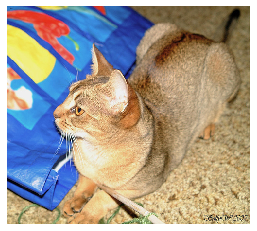

In [3]:
import matplotlib.pyplot as plt
from tensorflow.keras.utils import load_img, img_to_array
plt.axis("off")
plt.imshow(load_img(data_paths[9]))

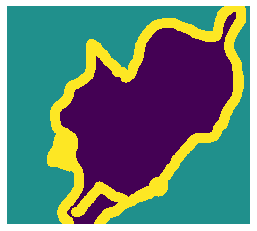

In [4]:
def display_target(target_array):
    normalized_array = (target_array.astype("uint8") - 1) * 127
    plt.axis("off")
    plt.imshow(normalized_array[:, :, 0])
    
'''
The original labels are 1, 2, and 3. We subtract 1 so that the
labels range from 0 to 2, and then we multiply by 127 so that
the labels become 0 (black), 127 (gray), 254 (near-white).
'''
    
img = img_to_array(load_img(target_paths[9], color_mode="grayscale"))
display_target(img)

In [5]:
import numpy as np

image_size = (200, 200)
n_images = len(data_paths)

mixed_indexes = np.random.permutation(len(data_paths))

data_paths_mixed = [data_paths[i] for i in mixed_indexes]
target_paths_mixed = [target_paths[i] for i in mixed_indexes]

In [6]:
def path_2_data(path):
    return img_to_array(load_img(path, target_size=image_size))

In [7]:
def path_2_target(path):
    img = img_to_array(load_img(path, target_size=image_size, color_mode="grayscale"))
    img = img.astype("uint8") - 1
    return img

In [8]:
X = np.zeros(shape=(n_images, image_size[0], image_size[1], 3), dtype="float32")
X.shape

(7390, 200, 200, 3)

In [9]:
y = np.zeros(shape=(n_images, image_size[0], image_size[1], 1))
y.shape

(7390, 200, 200, 1)

In [10]:
for i in range(n_images):
    X[i] = path_2_data(data_paths_mixed[i])
    y[i] = path_2_target(target_paths_mixed[i])

In [11]:
n_validation = 1000

X_val, y_val = X[:n_validation], y[:n_validation]
X_train, y_train = X[n_validation:], y[n_validation:]

## Model

In [12]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

In [13]:
def get_model(image_size, n_classes):
    inputs = keras.Input(shape=( image_size[0], image_size[1], 3))
    x = layers.Rescaling(1./255)(inputs)
    x = layers.Conv2D(64, 3, strides=2, activation="relu", padding="same")(x)
    x = layers.Conv2D(64, 3, activation="relu", padding="same")(x)
    x = layers.Conv2D(128, 3, strides=2, activation="relu", padding="same")(x)
    x = layers.Conv2D(128, 3, activation="relu", padding="same")(x)
    x = layers.Conv2D(256, 3, strides=2, padding="same", activation="relu")(x)
    x = layers.Conv2D(256, 3, activation="relu", padding="same")(x)
    x = layers.Conv2DTranspose(256, 3, activation="relu", padding="same")(x)
    x = layers.Conv2DTranspose(256, 3, activation="relu", padding="same", strides=2)(x)
    x = layers.Conv2DTranspose(128, 3, activation="relu", padding="same")(x)
    x = layers.Conv2DTranspose(128, 3, activation="relu", padding="same", strides=2)(x)
    x = layers.Conv2DTranspose(64, 3, activation="relu", padding="same")(x)
    x = layers.Conv2DTranspose(64, 3, activation="relu", padding="same", strides=2)(x)
    outputs = layers.Conv2D(n_classes, 3, activation="softmax",
    padding="same")(x)
    
    model = keras.Model(inputs=inputs, outputs=outputs)
    return model

In [14]:
model = get_model(image_size, 3)
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 200, 200, 3)]     0         
_________________________________________________________________
rescaling (Rescaling)        (None, 200, 200, 3)       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 100, 100, 64)      1792      
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 100, 100, 64)      36928     
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 50, 50, 128)       73856     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 50, 50, 128)       147584    
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 25, 25, 256)       295168

In [15]:
model.compile(optimizer="rmsprop", loss="sparse_categorical_crossentropy", metrics=['accuracy'])

callbacks = [keras.callbacks.ModelCheckpoint("oxford_segmentation.keras", save_best_only=True)]

history = model.fit(X_train, y_train,
                    epochs=50,
                    callbacks=callbacks,
                    batch_size=64,
                    validation_data=(X_val, y_val))

Epoch 1/50


ResourceExhaustedError:  OOM when allocating tensor with shape[64,200,200,3] and type float on /job:localhost/replica:0/task:0/device:CPU:0 by allocator cpu
	 [[{{node GatherV2}}]]
	 [[IteratorGetNext]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info. This isn't available when running in Eager mode.
 [Op:__inference_train_function_2097]

Function call stack:
train_function
